# LSTM MLP with Constituent Tree Parse (part 1)

In [10]:
import numpy as np
import pandas as pd
import os
import gc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline  

## Get Data

In [11]:
# file PubMed_20k_RCT.csv created by script01_create_single_dataset
df_all = pd.read_csv('input/PubMed_20k_RCT_CONSTPARSE.csv')
df_train = df_all[df_all['partition']=='train']
df_valid = df_all[df_all['partition']=='dev']
df_test = df_all[df_all['partition']=='test']
pd.set_option('max_colwidth',500)
df_all.head()

,partition,abstract_id,seq,text,label,deptree,deptree2
0,train,4293578,0,"To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .",OBJECTIVE,"( ROOT ( S ( S ( VP ( TO ) ( VP ( VB ) ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( JJ ) ( JJ ) ( JJ ) ( NN ) ) ) ) ) ) ( PP ( IN ) ( S ( VP ( VBG ) ( NP ( NP ( NN ) ) ( , ) ( NP ( NN ) ) ( , ) ( CC ) ( NP ( NP ( JJ ) ( JJ ) ( NN ) ) ( PP ( IN ) ( NP ( DT ) ( JJ ) ( NN ) ) ) ) ) ) ) ) ) ) ) ( CC ) ( S ( NP ( IN ) ( DT ) ( NN ) ) ( VP ( MD ) ( VP ( VB ) ( VP ( VBN ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( NP ( JJR ) ( NNS ) ) ( PP ( IN ...","( ROOT ( S ( S ( VP ( TO ) ( VP ( VB ) ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( JJ ) ( JJ ) ( JJ ) ( NN ) ) ) ) ) ) ( PP ( IN ) ( S ( VP ( VBG ) ( NP ( NP ( NN ) ) ( , ) ( NP ( NN ) ) ( , ) ( CC ) ( NP ( NP ( JJ ) ( JJ ) ( NN ) ) ( PP ( IN ) ( NP ( DT ) ( JJ ) ( NN ) ) ) ) ) ) ) ) ) ) ) ( CC ) ( S ( NP ( IN ) ( DT ) ( NN ) ) ( VP ( MD ) ( VP ( VB ) ( VP ( VBN ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( NP ( JJR ) ( NNS ) ) ( PP ( IN ..."
1,train,4293578,1,A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .,METHODS,( ROOT ( S ( S ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( JJ ) ( NN ) ( NN ) ) ) ) ) ) ( VP ( VBD ) ( VP ( VBN ) ( NP ( CD ) ) ) ) ) ( : ) ( S ( NP ( CD ) ) ( VP ( VBD ) ( SBAR ( S ( NP ( NP ( CD ) ( NN mg/day ) ) ( PP ( IN ) ( NP ( NP ( NN ) ) ( CC ) ( NP ( CD ) ) ) ) ) ( VP ( VBD ) ( NP ( NN ) ) ( PP ( IN ) ( NP ( CD ) ( NNS ) ) ) ) ) ) ) ) ( . ) ) ),( ROOT ( S ( S ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( CD ) ( NNS ) ) ( PP ( IN ) ( NP ( JJ ) ( NN ) ( NN ) ) ) ) ) ) ( VP ( VBD ) ( VP ( VBN ) ( NP ( CD ) ) ) ) ) ( ( S ( NP ( CD ) ) ( VP ( VBD ) ( SBAR ( S ( NP ( NP ( CD ) ( NN ) ( PP ( IN ) ( NP ( NP ( NN ) ) ( CC ) ( NP ( CD ) ) ) ) ) ( VP ( VBD ) ( NP ( NN ) ) ( PP ( IN ) ( NP ( CD ) ( NNS ) ) ) ) ) ) ) ) ( . ) ) )
2,train,4293578,2,Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .,METHODS,( ROOT ( S ( NP ( NN ) ( NNS ) ) ( VP ( VBD ) ( NP ( NN ) ( NN ) ( CC ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( NN ) ( NNS ) ) ( CC ) ( NP ( JJ ) ( NN ) ( NNS ) ) ) ) ) ( . ) ) ),( ROOT ( S ( NP ( NN ) ( NNS ) ) ( VP ( VBD ) ( NP ( NN ) ( NN ) ( CC ) ( NN ) ) ( PP ( IN ) ( NP ( NP ( NN ) ( NNS ) ) ( CC ) ( NP ( JJ ) ( NN ) ( NNS ) ) ) ) ) ( . ) ) )
3,train,4293578,3,Pain was assessed using the visual analog pain scale ( 0-100 mm ) .,METHODS,( ROOT ( S ( NP ( NN ) ) ( VP ( VBD ) ( VP ( VBN ) ( S ( VP ( VBG ) ( NP ( NP ( DT ) ( JJ ) ( NN ) ( NN ) ( NN ) ) ( PRN ( -LRB- ) ( NP ( CD ) ( NN ) ) ( -RRB- ) ) ) ) ) ) ) ( . ) ) ),( ROOT ( S ( NP ( NN ) ) ( VP ( VBD ) ( VP ( VBN ) ( S ( VP ( VBG ) ( NP ( NP ( DT ) ( JJ ) ( NN ) ( NN ) ( NN ) ) ( PRN ( LRB ) ( NP ( CD ) ( NN ) ) ( RRB ) ) ) ) ) ) ) ( . ) ) )
4,train,4293578,4,"Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .",METHODS,"( ROOT ( S ( NP ( JJ ) ( NN ) ( NNS ) ) ( VP ( VBD ) ( NP ( NP ( NP ( DT ) ( JJ ) ( NNP ) ( CC ) ( NNP ) ( NNS ) ) ( NP ( NNP ) ( NNP ) ( NNS ) ) ) ( , ) ( NP ( NP ( NP ( NN ) ( JJ ) ( NN ) ) ( PRN ( -LRB- ) ( NP ( NN ) ) ( -RRB- ) ) ) ( PP ( IN ) ( NP ( NP ( DT ) ( NN ) ) ( PP ( IN ) ( NP ( NN ) ( NN ) ) ) ) ) ) ( , ) ( CC ) ( NP ( NP ( JJ ) ( NN ) ( NN ) ) ( PRN ( -LRB- ) ( NP ( NN ) ) ( -RRB- ) ) ) ) ) ( . ) ) )","( ROOT ( S ( NP ( JJ ) ( NN ) ( NNS ) ) ( VP ( VBD ) ( NP ( NP ( NP ( DT ) ( JJ

In [12]:
X_train_cnt = df_train.shape[0]
X_valid_cnt = df_valid.shape[0]
X_test_cnt = df_test.shape[0]

X_all = df_all.deptree2.values

print('Train partition size: {}'.format(X_train_cnt))
print('Valid partition size: {}'.format(X_valid_cnt))
print('Test partition size: {}'.format(X_test_cnt))
print('Total dataset size: {}'.format(X_all.shape[0]))

Train partition size: 180040
Valid partition size: 30212
Test partition size: 30135
Total dataset size: 240387


## Create token sequences

In [13]:
%%time

# will only use 50 most common tokens

all_text = ' '.join(X_all)
all_tokens = [token for token in all_text.split()]
top_tokens = Counter(all_tokens).most_common(50)
i = 0
word_index = {k:i+1 for i, (k, _) in enumerate(top_tokens)}

VOC_SIZE = len(word_index)
print('Vocabulary size = {}'.format(VOC_SIZE))

Vocabulary size = 50
CPU times: user 7.31 s, sys: 2.63 s, total: 9.94 s
Wall time: 13.9 s


In [14]:
sequences = [[word_index[token] for token in parsetree.split() if word_index.get(token,-1)!=-1] for parsetree in X_all]

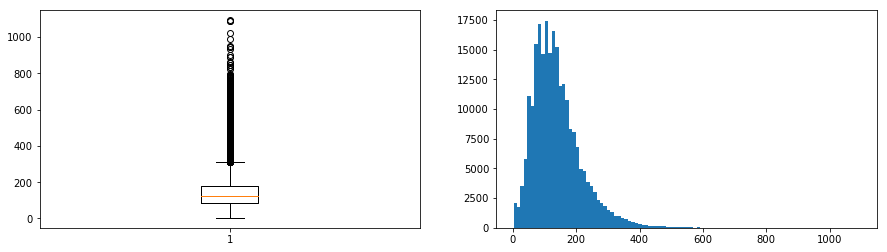

In [15]:
seq_len = [len(seq) for seq in sequences]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].boxplot(seq_len)
axes[1].hist(seq_len, bins=100)
plt.show()

In [16]:
MAX_SEQ_LEN = 300
X_token_seq_all = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, dtype='int32', padding='pre', truncating='post', value=0)
print(X_token_seq_all.shape)

(240387, 300)


## Vectorize output labels

In [17]:
%%time

labels = df_all.label.values
label_dict = {label: no for no, label in enumerate(set(labels))}
number_of_classes = len(label_dict)

# get labels as integers
y_all = [label_dict[label] for label in labels]

# change y to categorical (vectorize output)
y_all = np.array([to_categorical(i, num_classes=number_of_classes) for i in y_all])

CPU times: user 3.09 s, sys: 64.4 ms, total: 3.16 s
Wall time: 4.01 s


## Onehot encode Parse Tree labels

In [18]:
print(X_token_seq_all.shape)
X_token_seq_all

(240387, 300)


array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ..., 
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]], dtype=int32)

In [19]:
%%time

EMBEDDING_DIM = VOC_SIZE

def get_vector(token):
    vector = np.zeros(EMBEDDING_DIM)
    if token != 0:
        vector[token-1] = 1
    return vector

X_token_seq_all_v = np.zeros((X_token_seq_all.shape[0], X_token_seq_all.shape[1] * EMBEDDING_DIM))
print(X_token_seq_all_v.shape)
i = 0
for token_seq in X_token_seq_all:
    X_token_seq_all_v[i] = np.array([get_vector(token) for token in token_seq]).flatten()
    i += 1
    
print(X_token_seq_all_v.shape)

(240387, 15000)
(240387, 15000)
CPU times: user 8min 57s, sys: 18.6 s, total: 9min 16s
Wall time: 11min 50s


In [26]:
%%time

from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, Flatten, Dropout, Dense
from keras.callbacks import EarlyStopping

WINDOW = 3   # number of tokens in one timestep
TIMESTEP = EMBEDDING_DIM
TIME_LENGTH = 300

# reshape input 
X_seq_input = X_token_seq_all_v.reshape(X_token_seq_all_v.shape[0], TIMESTEP, TIME_LENGTH)

print(X_seq_input.shape)

sequence_input = Input(shape=(TIMESTEP, TIME_LENGTH), dtype='float32')
lstm = LSTM(units=TIMESTEP * 5, return_sequences=False)(sequence_input)
D1 = Dense(100, activation='relu', name='sentence_vector_1')(lstm)
D1 = Dropout(0.5)(D1)
D1 = Dense(20, activation='relu', name='sentence_vector_2')(D1)
D1 = Dropout(0.5)(D1)
preds = Dense(len(label_dict), activation='softmax')(D1)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

# learn
model.fit(X_seq_input[:X_train_cnt], y_all[:X_train_cnt], \
          validation_data=(X_seq_input[X_train_cnt:(X_train_cnt+X_valid_cnt)], \
                                 y_all[X_train_cnt:(X_train_cnt+X_valid_cnt)]), \
          callbacks=[EarlyStopping(patience=1, monitor='val_loss')], \
          verbose=1, epochs=20, batch_size=256)

model1 = model

(240387, 50, 300)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 50, 300)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 250)               551000    
_________________________________________________________________
sentence_vector_1 (Dense)    (None, 100)               25100     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
sentence_vector_2 (Dense)    (None, 20)                2020      
_________________________________________________________________
dropout_14 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 105

## Save model

In [15]:
model1.save('input/Extension_Part1_LSTM_CONSTPARSE1.h5')